In [10]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import os
from ripple_heterogeneity.utils import functions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statsmodels.stats.proportion import proportions_ztest
from statannotations.Annotator import Annotator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels' #change to v7
functions.set_plotting_defaults()

## find data files

In [2]:

files = glob.glob(r"Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_analysis\**/*.csv",recursive=True)

dirnames = [os.path.dirname(file) for file in files]
dirnames = np.unique(dirnames)

## load data

In [16]:
df = pd.DataFrame()
for dirname in dirnames:
    layer_id = pd.read_csv(glob.glob(os.path.join(dirname,"*layerID.csv"))[0])

    red_cells_file = glob.glob(os.path.join(dirname,"*redcells.csv"))
    green_cells_file = glob.glob(os.path.join(dirname,"*greencells.csv"))
    colabel_cells_file = glob.glob(os.path.join(dirname,"*colabel.csv"))
    calb_cells_file = glob.glob(os.path.join(dirname,"*calb.csv"))


    if len(red_cells_file) > 0:
        df_temp = pd.read_csv(red_cells_file[0])
        df_temp["color"] = "red"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(green_cells_file) > 0:
        df_temp = pd.read_csv(green_cells_file[0])
        df_temp["color"] = "green"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(colabel_cells_file) > 0:
        df_temp = pd.read_csv(colabel_cells_file[0])
        df_temp["color"] = "co_label"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)
    if len(calb_cells_file) > 0:
        df_temp = pd.read_csv(calb_cells_file[0])
        df_temp["color"] = "calb"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    df.loc[df.folder_name == dirname,"layer_rad_y"] = layer_id.Y.iloc[0]
    df.loc[df.folder_name == dirname,"layer_or_y"] = layer_id.Y.iloc[1]

df["normalized_dist"] = np.abs(df.Y - df.layer_rad_y) / abs(df.layer_rad_y - df.layer_or_y)
df
#df.to_csv(r"C:\Users\Cornell\Downloads\df.csv",index=False)

,,Area,Mean,Min,Max,X,Y,Ch,Slice,color,folder_name,layer_rad_y,layer_or_y,normalized_dist
0,1,0.0,392,392,392,229.494,181.153,1,1,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.223314
1,2,0.0,488,488,488,131.200,172.926,1,1,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.318324
2,3,0.0,310,310,310,94.563,171.400,1,1,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.335947
3,4,0.0,438,438,438,260.959,174.453,1,1,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.300689
4,5,0.0,394,394,394,38.588,160.205,1,1,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.465233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,27,0.0,9310,9310,9310,113.844,200.748,1,12,calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.226162
752,28,0.0,6696,6696,6696,216.970,168.883,1,8,calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.525891
753,29,0.0,4600,4600,4600,190.899,164.249,1,8,calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.569479
754,30,0.0,3944,3944,3944,11.877,143.971,1,4,calb,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.760217


In [17]:
sf_ind = pd.DataFrame()
for dirname in dirnames:
    layer_id = pd.read_csv(glob.glob(os.path.join(dirname,"*layerID.csv"))[0])


    redalone_cells_file = glob.glob(os.path.join(dirname,"*redalone.csv"))
    greenalone_cells_file = glob.glob(os.path.join(dirname,"*greenalone.csv"))

    if len(redalone_cells_file) > 0:
        sf_temp_ind = pd.read_csv(redalone_cells_file[0])
        sf_temp_ind["color"] = "redalone"
        sf_temp_ind["folder_name"] = dirname
        sf_ind = pd.concat([sf_ind,sf_temp_ind],ignore_index=True)
    if len(greenalone_cells_file) > 0:
        sf_temp_ind = pd.read_csv(greenalone_cells_file[0])
        sf_temp_ind["color"] = "greenalone"
        sf_temp_ind["folder_name"] = dirname
        sf_ind = pd.concat([sf_ind,sf_temp_ind],ignore_index=True)


    sf_ind.loc[sf_ind.folder_name == dirname,"layer_rad_y"] = layer_id.Y.iloc[0]
    sf_ind.loc[sf_ind.folder_name == dirname,"layer_or_y"] = layer_id.Y.iloc[1]

sf_ind["normalized_dist"] = np.abs(sf_ind.Y - sf_ind.layer_rad_y) / abs(sf_ind.layer_rad_y - sf_ind.layer_or_y)
sf_ind

,,Area,Mean,Min,Max,X,Y,Ch,Slice,color,folder_name,layer_rad_y,layer_or_y,normalized_dist
0,1,0.0,757,757,757,40.200,174.029,1,1,redalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.305586
1,2,0.0,721,721,721,31.973,162.241,1,1,redalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.441720
2,3,0.0,437,437,437,58.943,162.749,1,1,redalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.435854
3,4,0.0,785,785,785,54.363,158.170,1,1,redalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.488734
4,5,0.0,565,565,565,65.558,158.170,1,1,redalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,200.490,113.899,0.488734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,78,0.0,8591,8591,8591,125.431,147.447,1,16,redalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.727522
846,1,0.0,5648,5648,5648,204.514,168.594,1,6,greenalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.528609
847,2,0.0,2949,2949,2949,137.598,124.852,1,6,greenalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.940054
848,3,0.0,5609,5609,5609,125.431,124.852,1,6,greenalone,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.940054


In [19]:
red_green_ranksums=ranksums(df.query("color=='red'").normalized_dist,df.query("color=='green'").normalized_dist)
red_calb_ranksums=ranksums(df.query("color=='red'").normalized_dist,df.query("color=='calb'").normalized_dist)
green_calb_ranksums=ranksums(df.query("color=='green'").normalized_dist,df.query("color=='calb'").normalized_dist)



print(red_green_ranksums)
print(red_calb_ranksums)
print(green_calb_ranksums)


RanksumsResult(statistic=-2.9751343881952867, pvalue=0.0029286021862168212)
RanksumsResult(statistic=-1.563827379546485, pvalue=0.11785811254518819)
RanksumsResult(statistic=2.6995084589236393, pvalue=0.006944199041847074)


## plot smoothed distribution of distances per projection type

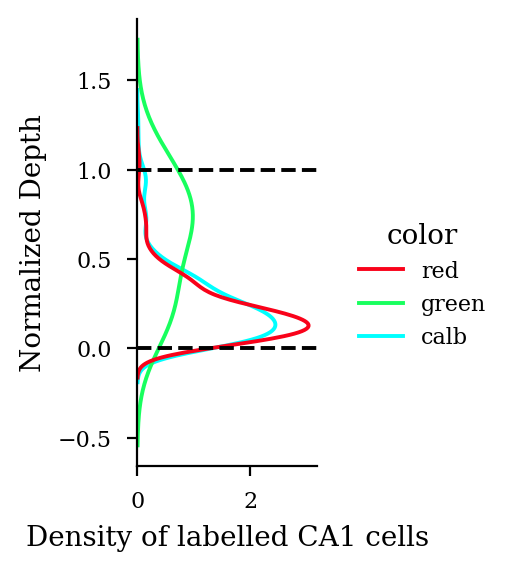

In [22]:
h,w = functions.set_size("thesis", fraction=.5, subplots=(1, 1))

group_colors = {"red": "#f9021a", "green": "#18ff5e","calb":"#00FFFF"}





sns.set_palette(sns.color_palette(group_colors.values()))


sns.displot(df, y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=False,height=h,aspect=w/h,alpha=1)






plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("Density of labelled CA1 cells")
plt.ylabel("Normalized Depth")

plt.savefig(os.path.join(fig_save_path,'Normalized_depth_labelled_CA1_cells_Calb.svg'),dpi=300,bbox_inches='tight')


In [20]:
from scipy.stats import ttest_ind

red_green_ind_ttest=ttest_ind(df.query("color=='red'").normalized_dist,df.query("color=='green'").normalized_dist)
red_calb_ind_ttest=ttest_ind(df.query("color=='red'").normalized_dist,df.query("color=='calb'").normalized_dist)
green_calb_ind_ttest=ttest_ind(df.query("color=='green'").normalized_dist,df.query("color=='calb'").normalized_dist)


print(red_green_ind_ttest)
print(red_calb_ind_ttest)
print(green_calb_ind_ttest)

Ttest_indResult(statistic=-5.437439972207409, pvalue=1.0767411338794734e-07)
Ttest_indResult(statistic=-2.189334684335388, pvalue=0.028880823260828747)
Ttest_indResult(statistic=4.085015870239502, pvalue=5.239500875055152e-05)


##Z test between red, green and calb distances


In [ ]:



red_green_zscore=zscore(df.query("color=='Red-Calb'").normalized_dist,df.query("color=='Green-Calb'").normalized_dist)



red_calb_zscore=zscore(df.query("color=='Red-Calb'").normalized_dist,df.query("color=='Calb'").normalized_dist)



green_calb_zscore=zscore(df.query("color=='Green-Calb'").normalized_dist,df.query("color=='Calb'").normalized_dist)

print(red_green_zscore)
print(red_calb_zscore)
print(green_calb_zscore)


## get proportions of cells based on calb

In [25]:
prop_df = df.groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1

prop_calb_df = pd.DataFrame(data)
prop_calb_df["constant"] = 1


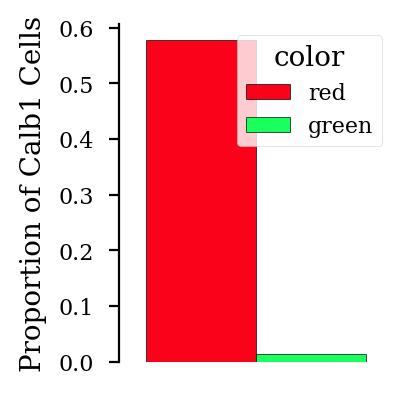

In [27]:
plt.figure(figsize = functions.set_size("thesis", fraction=.3, subplots=(2, 1)))
group_colors_percentage = {"red": "#f9021a", "green": "#18ff5e"}

sns.barplot(data=prop_calb_df,x="constant", hue="color", y="percentage",hue_order=group_colors_percentage,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("Proportion of Calb1 Cells")
plt.xlabel("")
# turn x axis labels off
plt.xticks([])
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells_calb.svg'),dpi=300,bbox_inches='tight')
# plt.ylim(0,.75)
